
[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Dataset preview:
        age  symptom_score  blood_test_1  blood_test_2  blood_test_3  \
0 -0.141672      -0.854691     -2.428524     -0.985944     -0.276859   
1 -0.155660      -1.945939      2.957537     -2.924643      0.595406   
2 -0.580224       1.181034     -0.985934     -1.197192     -0.146491   
3 -0.790385       1.758204     -1.775463     -0.051727      1.650230   
4 -0.512209       0.462537     -1.110117     -2.064864     -0.930408   

        bmi  blood_pressure  cholesterol   glucose  smoking_status  disease  
0 -1.780009       -0.582772     2.753086 -2.228598        1.719410        1  
1  3.191508       -1.363597    -7.661843  7.371203       -2.197920        0  
2  0.020389       -0.031219    -0.542246 -0.320481       -0.830218        0  
3  1.772357        0.154436    -0.175627  0.682166       -1.107111        0  
4  1.211368        0.261978    -2.352889  1.189882       -0.446651        1  


C:\Users\Lenovo\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:199: UserWarning: [16:41:34] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



LogisticRegression Classification Report:
              precision    recall  f1-score   support

           0     0.6518    0.7451    0.6954       412
           1     0.6237    0.5148    0.5640       338

    accuracy                         0.6413       750
   macro avg     0.6377    0.6300    0.6297       750
weighted avg     0.6391    0.6413    0.6362       750

LogisticRegression ROC-AUC: 0.6755

RandomForest Classification Report:
              precision    recall  f1-score   support

           0     0.9328    0.9102    0.9214       412
           1     0.8937    0.9201    0.9067       338

    accuracy                         0.9147       750
   macro avg     0.9133    0.9152    0.9140       750
weighted avg     0.9152    0.9147    0.9148       750

RandomForest ROC-AUC: 0.9641

XGBoost Classification Report:
              precision    recall  f1-score   support

           0     0.9242    0.9175    0.9208       412
           1     0.9003    0.9083    0.9043       338

    ac

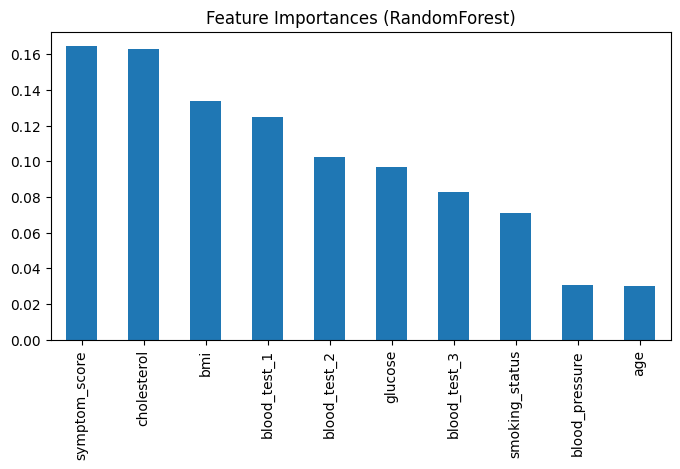

Saved scaler and RandomForest model.


In [3]:
# Task 4: Disease Prediction (synthetic medical dataset)
# Run in Jupyter.

!pip install -q scikit-learn xgboost pandas matplotlib

import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import joblib

# Try to import xgboost (optional)
try:
    import xgboost as xgb
    has_xgb = True
except Exception as e:
    print("xgboost not available; will skip XGBoost model. Error:", e)
    has_xgb = False

# 1) Create synthetic medical dataset
# Features named to mimic medical data (age, symptoms, blood_test1, etc.)
X, y = make_classification(n_samples=3000, n_features=10, n_informative=6, n_redundant=2,
                           n_clusters_per_class=2, weights=[0.55, 0.45], flip_y=0.02, random_state=7)

feature_names = ['age', 'symptom_score', 'blood_test_1', 'blood_test_2', 'blood_test_3',
                 'bmi', 'blood_pressure', 'cholesterol', 'glucose', 'smoking_status']
df = pd.DataFrame(X, columns=feature_names)
df['disease'] = y
print("Dataset preview:")
print(df.head())

# 2) Split and scale
X = df[feature_names].values
y = df['disease'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_test_s = scaler.transform(X_test)

# 3) Train models
log = LogisticRegression(max_iter=1000, random_state=42)
rf = RandomForestClassifier(n_estimators=200, random_state=42)

log.fit(X_train_s, y_train)
rf.fit(X_train_s, y_train)

models = {"LogisticRegression": log, "RandomForest": rf}

if has_xgb:
    xg = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
    xg.fit(X_train_s, y_train)
    models['XGBoost'] = xg

# 4) Evaluate
for name, model in models.items():
    y_pred = model.predict(X_test_s)
    y_proba = model.predict_proba(X_test_s)[:,1] if hasattr(model, "predict_proba") else None
    print(f"\n{name} Classification Report:")
    print(classification_report(y_test, y_pred, digits=4))
    if y_proba is not None:
        print(f"{name} ROC-AUC: {roc_auc_score(y_test, y_proba):.4f}")

# 5) Feature importance (RandomForest)
importances = rf.feature_importances_
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)
print("\nRandomForest feature importances:")
print(feat_imp)

plt.figure(figsize=(8,4))
feat_imp.plot(kind='bar')
plt.title("Feature Importances (RandomForest)")
plt.show()

# 6) Save best model (based on ROC-AUC roughly)
best_model = rf
joblib.dump(scaler, "disease_scaler.joblib")
joblib.dump(best_model, "disease_random_forest.joblib")
print("Saved scaler and RandomForest model.")
